<a href="https://colab.research.google.com/github/POBOROJO/TEXT-SUMMARISER/blob/main/Bengali_Text_summarization_with_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os

for dirname, _, filenames in os.walk("/content/drive/My Drive/IITG"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/drive/My Drive/IITG/pickle_stored.pkl
/content/drive/My Drive/IITG/cc.bn.300.bin
/content/drive/My Drive/IITG/train.csv
/content/drive/My Drive/IITG/BiLSTM-LSTM_weights.h5
/content/drive/My Drive/IITG/LSTM_LSTM_weights.h5


# **Pickle loaded**

In [ ]:
import pickle
dict_load = pickle.load(open("/content/drive/MyDrive/IITG/pickle_stored.pkl", 'rb'))
x_voc=dict_load['x_voc']
y_voc=dict_load['y_voc']
text = dict_load['text']
summary=dict_load['summary']
x_tr=dict_load['x_tr']
y_tr=dict_load['y_tr']
x_val=dict_load['x_val']
y_val=dict_load['y_val']
ft_embedding_matrix_encoder=dict_load['ft_embedding_matrix_encoder']
ft_embedding_matrix_decoder=dict_load['ft_embedding_matrix_decoder']
x_tokenizer=dict_load['x_tokenizer']
y_tokenizer=dict_load['y_tokenizer']
max_text_len=dict_load['max_text_len']
max_summary_len=dict_load['max_summary_len']

## **Pickle Dump**

In [ ]:
# import pickle
# object_dict ={
#     'x_voc':x_voc,
#     'y_voc':y_voc,
#     'text':text,
#     'summary':summary,
#     'x_tr':x_tr,
#     'y_tr':y_tr,
#     'x_val':x_val,
#     'y_val':y_val,
#     'ft_embedding_matrix_encoder':ft_embedding_matrix_encoder,
#     'ft_embedding_matrix_decoder':ft_embedding_matrix_decoder,
#     'x_tokenizer':x_tokenizer,
#     'y_tokenizer':y_tokenizer,
#     'max_text_len':max_text_len,
#     'max_summary_len':max_summary_len,
# }

# pickle.dump(object_dict, open("/content/drive/MyDrive/IITG/pickle_stored.pkl", 'wb'))

# **Read CSV**

In [ ]:
Bset = pd.read_csv('/content/drive/MyDrive/IITG/train.csv', encoding='utf-8') # char encoding used to interpret the text data in the CSV file

**encoding='iso-8859-1**, seems to refer to a character encoding specification

In [ ]:
Bset.head()

,title,article,label
0,এই অভিনেতার ‘প্রস্তাব’ মানলে ভারতীয় সিনেমার খো...,স্রেফ দু’টি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফে...,entertainment
1,"সচিন সাংসদ হয়েছেন, তাই চিন্তা কম জেটলির। কেন?",একবার রেল বাজেট। একবার সাধারণ বাজেট। খবরের শি...,national
2,ক্রিকেটার থেকে গাইড! জাতীয় দলের ক্রিকেটারের অব...,কিছুদিন আগেই রাজ্যের গাইড বনে গিয়েছিলেন চেতেশ...,sports
3,"দুষ্কৃতীদের নজরে এটিএম, হাল হকিকত্ ঘুরে দেখলেন...",কলকাতায় দুষ্কৃতীদের নজরে এখন বিভিন্ন ব্যাঙ্কের...,kolkata
4,"সৌজন্যের বালাই নেই, দিনভর আকচা আকচি কং-বিজেপি’র",সারা দিন আকচা আকচিতেই কাটিয়ে দিল দেশের দুই বৃহ...,national


In [ ]:
column_to_remove = 'label'

Bset= Bset.drop(columns=[column_to_remove])
summary=Bset

In [ ]:
summary.head()

,title,article
0,এই অভিনেতার ‘প্রস্তাব’ মানলে ভারতীয় সিনেমার খো...,স্রেফ দু’টি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফে...
1,"সচিন সাংসদ হয়েছেন, তাই চিন্তা কম জেটলির। কেন?",একবার রেল বাজেট। একবার সাধারণ বাজেট। খবরের শি...
2,ক্রিকেটার থেকে গাইড! জাতীয় দলের ক্রিকেটারের অব...,কিছুদিন আগেই রাজ্যের গাইড বনে গিয়েছিলেন চেতেশ...
3,"দুষ্কৃতীদের নজরে এটিএম, হাল হকিকত্ ঘুরে দেখলেন...",কলকাতায় দুষ্কৃতীদের নজরে এখন বিভিন্ন ব্যাঙ্কের...
4,"সৌজন্যের বালাই নেই, দিনভর আকচা আকচি কং-বিজেপি’র",সারা দিন আকচা আকচিতেই কাটিয়ে দিল দেশের দুই বৃহ...


# **Pre- processing data**

> **Now we perform Data Cleansing**

In [ ]:
import re

def clean_text(text):
    # Define emoji removal pattern
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u2066"
                               u"\u2069"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    # Remove English letters, links, numbers, and special characters
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'[a-zA-Z]+', '', text)  # Remove English letters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r"[<>()|&©ø@\[\]\'\",;#?~*!।/—:.]", ' ', text)  # Remove special characters

    # Remove punctuation and special characters
    punc = '''؛₹|!‼→¿()-[]{};–৷।:،۔•„'“‘—’”"…\,<>=./?@#$%^&*_~»«'''
    for ele in text:
        if ele in punc:
            text = text.replace(ele, "")

    # Remove emojis
    text = emoji_pattern.sub(r'', text)

    # Remove extra whitespaces
    text = re.sub(r"^\s+|\s+$", "", text)
    text = re.sub(' +', ' ', text)

    text = bytes(text, 'utf-8').decode('utf-8', 'ignore')

    return text

# Apply the combined cleaning function to the columns you want to modify
summary['title'] = summary['title'].apply(clean_text)
summary['article'] = summary['article'].apply(clean_text)


In [ ]:
summary.head()

,title,article
0,এই অভিনেতার প্রস্তাব মানলে ভারতীয় সিনেমার খোলন...,স্রেফ দুটি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফেলে...
1,সচিন সাংসদ হয়েছেন তাই চিন্তা কম জেটলির কেন,একবার রেল বাজেট একবার সাধারণ বাজেট খবরের শিরোন...
2,ক্রিকেটার থেকে গাইড জাতীয় দলের ক্রিকেটারের অবা...,কিছুদিন আগেই রাজ্যের গাইড বনে গিয়েছিলেন চেতেশ্...
3,দুষ্কৃতীদের নজরে এটিএম হাল হকিকত্ ঘুরে দেখলেন ...,কলকাতায় দুষ্কৃতীদের নজরে এখন বিভিন্ন ব্যাঙ্কের...
4,সৌজন্যের বালাই নেই দিনভর আকচা আকচি কংবিজেপির,সারা দিন আকচা আকচিতেই কাটিয়ে দিল দেশের দুই বৃহ...


Q. Why are we replacing non-alphabetical characters with single space here ?

Ans -  As single space is a common text preprocessing technique so as to simplify the text and reduce noise.
   * Improved Readability
   * Uniformity
   * Simplifying Text Analysis, etc

In [ ]:
pre = summary.rename(columns={'title': 'summary', 'article': 'text'}, inplace=False)

In [ ]:
pre.head()

,summary,text
0,এই অভিনেতার প্রস্তাব মানলে ভারতীয় সিনেমার খোলন...,স্রেফ দুটি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফেলে...
1,সচিন সাংসদ হয়েছেন তাই চিন্তা কম জেটলির কেন,একবার রেল বাজেট একবার সাধারণ বাজেট খবরের শিরোন...
2,ক্রিকেটার থেকে গাইড জাতীয় দলের ক্রিকেটারের অবা...,কিছুদিন আগেই রাজ্যের গাইড বনে গিয়েছিলেন চেতেশ্...
3,দুষ্কৃতীদের নজরে এটিএম হাল হকিকত্ ঘুরে দেখলেন ...,কলকাতায় দুষ্কৃতীদের নজরে এখন বিভিন্ন ব্যাঙ্কের...
4,সৌজন্যের বালাই নেই দিনভর আকচা আকচি কংবিজেপির,সারা দিন আকচা আকচিতেই কাটিয়ে দিল দেশের দুই বৃহ...


In [ ]:
text_clean=pre['summary']

In [ ]:
import pandas as pd

# Assuming 'pre' is your DataFrame
# and you want to apply the text_apply function to a specific column

def text_apply(summary):
    a = '_START_ ' + summary + ' _END_'
    return a

# Make sure you replace 'summary' with the actual column name you want to process
pre['summary'] = pre['summary'].apply(text_apply)


In [ ]:
pre['summary'][:10]

0    _START_ এই অভিনেতার প্রস্তাব মানলে ভারতীয় সিনে...
1    _START_ সচিন সাংসদ হয়েছেন তাই চিন্তা কম জেটলির...
2    _START_ ক্রিকেটার থেকে গাইড জাতীয় দলের ক্রিকেট...
3    _START_ দুষ্কৃতীদের নজরে এটিএম হাল হকিকত্ ঘুরে...
4    _START_ সৌজন্যের বালাই নেই দিনভর আকচা আকচি কংব...
5    _START_ নোট বদলের ধাক্কায় কেমন হল বিয়ে জানুন _...
6                        _START_ সিপিএমের মুখিয়া _END_
7    _START_ গড়িয়ায় দফায় দফায় গণধর্ষণের শিকার অষ্টম...
8    _START_ বামেদের ধর্মঘটকে সমর্থন নবান্ন অভিযানে...
9                     _START_ আকাশবাড়ির হাতছানি _END_
Name: summary, dtype: object

In [ ]:
text_count = [] # list
summary_count = []

In [ ]:
for sent in pre['text']: #iterates over each sentences in 'cleaned_text'
    text_count.append(len(sent.split()))

    #calculates word count of the sentence and appends the count to 'text_count'

    #sentence is split into words using split()

for sent in pre['summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

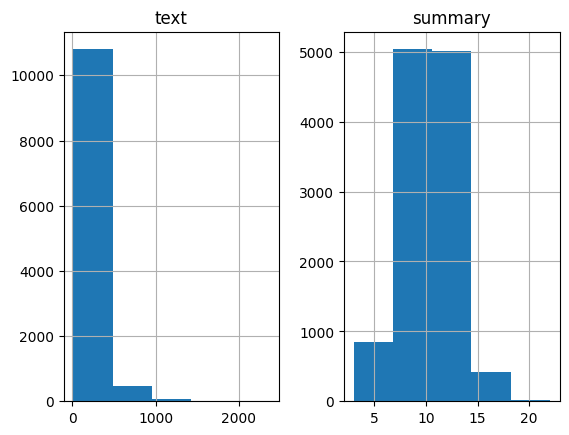

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5) #smaller bins - larger intervals and vice versa
plt.show()

#

In [ ]:
#Check how much % of summary have 0-20 words
cnt=0
for i in pre['summary']:
    if(len(i.split())<=16):
        cnt=cnt+1
print(cnt/len(pre['summary'])*100,'%')

99.39950547509714 %


In [ ]:
#Check how much % of text have 0-300 words
cnt=0
for i in pre['text']:
    if(len(i.split())<=300):
        cnt=cnt+1
print(cnt/len(pre['text'])*100,'%')

81.01377605086542 %


In [ ]:
#Model to summarize the text between 0-10 words for Summary and 0-300 words for Text
max_text_len=300
max_summary_len=16

# these values are found from the histogram

In [ ]:
#Select the Summaries and Text between max len defined above

text =np.array(pre['text'])
summary=np.array(pre['summary'])

short_text=[]
short_summary=[]

for i in range(len(text)):
    if(len(summary [i].split())<=max_summary_len and len(text[i].split())<=max_text_len):
        #length of the sentence in "summary  must be <=max_summary_len and lly max_text_len
        short_text.append(text[i])
        short_summary.append(summary [i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.head(2)

,text,summary
0,স্রেফ দুটি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফেলে...,_START_ এই অভিনেতার প্রস্তাব মানলে ভারতীয় সিনে...
1,একবার রেল বাজেট একবার সাধারণ বাজেট খবরের শিরোন...,_START_ সচিন সাংসদ হয়েছেন তাই চিন্তা কম জেটলির...


In [ ]:
len(post_pre)

9125

In [ ]:
#Add sostok and eostok at

#The tokens help the model in identifying the start and end of a sequence

# sostok-start token at the beginning # eostok -end token at the end of each sentences

post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

# lamda - takes a single argumnet x and represents each element (sentence) in the 'summary' column

In [ ]:
post_pre.head(2)

,text,summary
0,স্রেফ দুটি টুইটেই সোশ্যাল মিডিয়ায় তোলপাড় ফেলে...,sostok _START_ এই অভিনেতার প্রস্তাব মানলে ভারত...
1,একবার রেল বাজেট একবার সাধারণ বাজেট খবরের শিরোন...,sostok _START_ সচিন সাংসদ হয়েছেন তাই চিন্তা কম...


#**MODEL** BUILDING

Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.2,random_state=0,shuffle=True)
#here we split the data into training and validation sets to build the model
#data is shuffled in the same way every time we run the code with that particular random_state value

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

##### RARE WORD ANALYSIS FOR X i.e 'text'

* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [ ]:
thresh=3

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():#iterates through the word counts in the vocabulary
    #word_counts contains a dictionary with as words - keys and their frequencies - value
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.53451165258069
Total Coverage of rare words: 4.898090808469791


In [ ]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 31076


**RARE WORD ANALYSIS FOR Y i.e 'summary'**


*   tot_cnt gives the size of vocabulary (which means every unique words in the text)
*   cnt gives me the no. of rare words whose count falls below threshold

*   tot_cnt - cnt gives me the top most common words



In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 57.47687564234327
Total Coverage of rare words: 9.963366700442048


In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) #This parameter limits the tokenizer to consider only the most frequent words
y_tokenizer.fit_on_texts(list(y_tr)) #creates a word index based on frequency of words in the training data & assigns unique integer/tokens to each word

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
# Any sequences shorter than max_len will be padded with zeros at the end(as it is given 'post')

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))


Size of vocabulary in Y = 6621


We remove "Summary" i.e Y (both train and val) which has only START and END

i.e jo sare summary jin mein sirf START aur END hain unko remove karna hain kiuki woh khali hain

In [ ]:
#in the above code we are doing data filtering removing specific rows from both 'y_tr' and 'x_tr' arrays
ind=[] # stores indices of the rows to be removed
for i in range(len(y_tr)):
    cnt=0 # counts the non-zero elements
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0) #remove those rows from the 'y_tr' array along the first axis (axis=0 means rows rows).
x_tr=np.delete(x_tr,ind, axis=0)

specific condition is that only rows with exactly two non-zero elements (START and END only) are removed from both arrays

In [ ]:
ind=[] # similary we are doing here
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

 the model consists of an encoder with multiple LSTM layers to process the input sequences and capture their context, and a decoder with an LSTM layer and a dense layer to generate the output sequences.

**Fasttext model bin file uploaded**

In [ ]:
!wget -P /content/ "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.bin.gz"

--2023-08-11 13:26:43--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.154.144.74, 18.154.144.13, 18.154.144.87, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.154.144.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3934298272 (3.7G) [application/octet-stream]
Saving to: ‘/content/cc.bn.300.bin.gz’

cc.bn.300.bin.gz    100%[===================>]   3.66G  30.1MB/s    in 2m 4s   

2023-08-11 13:28:48 (30.2 MB/s) - ‘/content/cc.bn.300.bin.gz’ saved [3934298272/3934298272]



In [ ]:
!gzip -d /content/drive/MyDrive/IITG/cc.bn.300.bin

gzip: /content/drive/MyDrive/IITG/cc.bn.300.bin: unknown suffix -- ignored


In [ ]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=f4003546b523bba28a127725895ac323b0c5cad842e9cd2a55ebf425058c8b5c
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import fasttext as ft
ft_model = ft.load_model('/content/drive/MyDrive/IITG/cc.bn.300.bin')

**Embedding matrix created for both encoder and decoder**

embedding matrix- allows us to represent words or tokens in a dense vector space

In [ ]:
# Create the embedding matrix using the FastText model for encoder
ft_embedding_matrix_encoder = np.empty((x_voc, ft_model.get_dimension()))
i1=0
i2=0
for word, idx in x_tokenizer.word_index.items():
    if word in ft_model.words:
        ft_embedding_matrix_encoder[i1] = ft_model[word]
        i1+=1
    if i1==x_voc-1:
      break;


# Create the embedding matrix using the FastText model for decoder
ft_embedding_matrix_decoder = np.empty((y_voc, ft_model.get_dimension()))
for word, idx in y_tokenizer.word_index.items():
    if word in ft_model.words:
        ft_embedding_matrix_decoder[i2] = ft_model[word]
        i2+=1
    if i2==y_voc-1:
      break;


# **CuDNN** (**LSTM-LSTM**)

In [ ]:
from keras import backend as K
import fasttext as ft
from numpy import *
import numpy as np
import pandas as pd
from keras.layers import Input, LSTM, Embedding, Dense, TimeDistributed
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from keras.layers import CuDNNLSTM
K.clear_session()

# Assuming FastText was trained with an embedding dimension of 300
embedding_dim = 300
latent_dim=300
max_text_len=300

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer with FastText embeddings for the encoder
enc_emb = Embedding(x_voc, embedding_dim, weights=[ft_embedding_matrix_encoder], trainable=True)(encoder_inputs)

# Encoder LSTM layers (you can customize the number of layers and other parameters)
encoder_lstm1 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = CuDNNLSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)


# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding layer with FastText embeddings for the decoder
dec_emb_layer = Embedding(y_voc, embedding_dim, weights=[ft_embedding_matrix_decoder], trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM layers (you can customize the number of layers and other parameters)
decoder_lstm = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_fwd_state, decoder_back_state  = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# monitor parameter specifies the metric that the Early Stopping callback will monitor to determine when to stop training
#'val_loss' refers to the validation loss
# verbose=1 means that the callback will produce informative messages about the training progress, including notifications when the training is stopped due to early stopping conditions being met.
# patience=3 means that if the validation loss does not improve for two consecutive epochs, the training will be stopped early.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     9322800     ['input_1[0][0]']                
                                                                                                  
 cu_dnnlstm (CuDNNLSTM)         [(None, 300, 300),   722400      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
# we remove the last word [:,:-1] & the first word [:,1:] so that the model can predict the next one
#reshape is done because the decoder expects a 3d tensor
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128,verbose=1, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
58/58 [==============================] - 42s 512ms/step - loss: 5.2603 - val_loss: 3.8321
Epoch 2/50
58/58 [==============================] - 26s 459ms/step - loss: 4.0798 - val_loss: 3.5450
Epoch 3/50
58/58 [==============================] - 21s 366ms/step - loss: 3.9147 - val_loss: 3.4990
Epoch 4/50
58/58 [==============================] - 21s 360ms/step - loss: 3.8599 - val_loss: 3.4912
Epoch 5/50
58/58 [==============================] - 20s 344ms/step - loss: 3.8211 - val_loss: 3.4901
Epoch 6/50
58/58 [==============================] - 20s 334ms/step - loss: 3.7858 - val_loss: 3.5028
Epoch 7/50
58/58 [==============================] - 19s 328ms/step - loss: 3.7549 - val_loss: 3.5010
Epoch 8/50
58/58 [==============================] - 17s 296ms/step - loss: 3.7242 - val_loss: 3.5032
Epoch 8: early stopping


**Model weights saved**

In [ ]:
import tensorflow as tf

# Assuming you have already defined and compiled your model
# Save the model weights
model.save_weights("/content/drive/MyDrive/IITG/LSTM_LSTM_weights.h5")

**Model loaded**

In [ ]:
import tensorflow as tf

# Load the saved model weights
model.load_weights("/content/drive/MyDrive/IITG/LSTM_LSTM_weights.h5")

**Visualize the model learning**

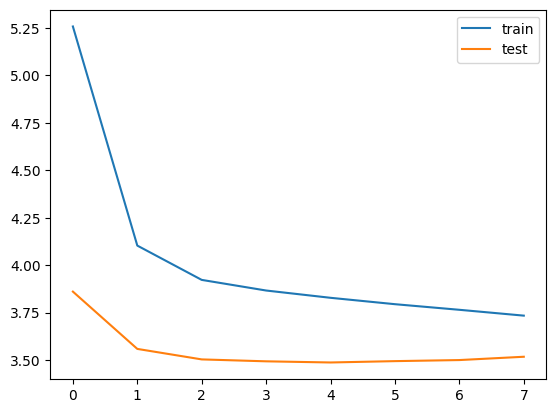

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

So now we are creating a new LSTM model here and in the previous LSTM model the weights were adjusted, and now the new LSTM model will use the adjusted LSTM model and test it on new data without changing the weights.



1. Here we have 2 models encoder and decoder made using Model()
2. encoder Model -> It takes the input text data (encoder_inputs) as input and returns the encoder outputs (encoder_outputs) and hidden state(state_h and state_c) as outputs

3. Decoder Setup:
These are input representing the hidden state and cell state
from the previous time step of the decoder LSTM

4. Decoder Embeddings:

dec_emb2: This line gets the embeddings of the decoder input sequence (decoder_inputs) using the decoder embedding layer (dec_emb_layer).

decoder_outputs2: The decoder LSTM outputs at each time step are passed through a dense softmax layer (decoder_dense) to generate the probability distribution over the target vocabulary.

5. Decoder Model:

decoder_model: This is the final decoder model used for inference. It takes the decoder input sequence (decoder_inputs) and the initial states (decoder_hidden_state_input, decoder_state_input_h, and decoder_state_input_c) as inputs.
The decoder model returns the predicted output tokens (decoder_outputs2) and the updated hidden state (state_h2) and cell state (state_c2) for the next time step.




In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq,verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c],verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**INPUT SEQUENCE TO SUMMARY**

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

Run the model over the data to see the results

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):  #  --> padding i.e., WE IGNORE 0
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: টানা দশম সব যেন একে অপরকে টেক্কা দেওয়ার নেমেছে কিন্তু যে সব পর্যটক ও ঘুরে এসেছেন তাঁদের অনেককেই বলতে শোনা যাচ্ছে এ বার কিন্তু তিনটে জলপ্রপাতের মধ্যে হল হিরো নম্বর ওয়ান এই বর্ষায় টেক্কা দেওয়া কঠিন শুরু হয়ে গিয়েছে স্বাধীনতা দিবসের ছুটির মরশুম সোমবার ছুটি নিলেই টানা তিনদিন ধরে ছুটি তাই পর্যটকদের ভিড়ও প্রচুর এমনিতেই দশম খুব জলপ্রপাত গত বছরে দশমের পাথরে বসে স্নান করতে গিয়ে বেশ কয়েকজন পর্যটকের মৃত্যু হয়েছে এবার দশমের এই সচেতন জলপ্রপাতের কর্মীরা তাঁরা বারবার পর্যটকদের জলপ্রপাতের বেশি কাছে যেতে নিষেধ করছেন দশমের রুদ্রমূর্তি দেখে বেশি সাহস দেখানোর চেষ্টা করছেন না কাঁচি নদীর এই জলপ্রপাতের দশটি ধারায় জল পড়ে বলে এর নাম দশম জলপ্রপাত তবে এই বর্ষায় সব জলের ধারা মিলে মিশে একাকার দশম সঙ্গে বিন্দু বিন্দু জল হাওয়ায় উড়িয়ে দিচ্ছে ওই বিন্দু বিন্দু জল একসঙ্গে জমাট বেধে চলে যাচ্ছে অনেক দূর তাই জলপ্রপাত থেকে অনেকটা দূরে দাঁড়িয়ে থাকলেও হালকা ভিজিয়ে দিচ্ছে দশম দশমের এ ভাবেই ভিজতে ভিজতে কোনও এক পর্যটক বলে ওঠেন একেই বলে বোধহয় ভয়ঙ্কর সুন্দর 
Original summary: start সবাইকে টেক্কা দিচ্ছে দশম end 
Predicte

**ROGUE SCORE**

In [ ]:
!pip install rouge

In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=7d1d644c21136eb70c9d0afb61aa77e23977586f6523b6f9e2166242f5fd7c89
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
def calculate_precision_recall_fmeasure(predicted_summary, original_summary):
    predicted_set = set(predicted_summary)
    reference_set = set(original_summary)

    # Calculate precision
    precision = len(predicted_set.intersection(reference_set)) / len(predicted_set)


    # Calculate recall
    if len(reference_set) > 0:
        recall = len(predicted_set.intersection(reference_set)) / len(reference_set)
    else:
        recall = 0.0


    # Calculate F-measure
    if precision + recall != 0:
        f_measure = 2 * (precision * recall) / (precision + recall)
    else:
        f_measure = 0.0


    return precision, recall, f_measure

In [ ]:
from rouge import Rouge
rouge=Rouge()

precision = []
recall = []
f_measure = []
Rough_f=[]
Rough_p=[]
Rough_r=[]

for i in range(1000):
    p, r, f= calculate_precision_recall_fmeasure(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    precision.append(p)
    recall.append(r)
    f_measure.append(f)

    # Calculate ROUGE scores using rouge library
    scores = rouge.get_scores(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    Rough_f.append(scores[0]['rouge-1']['f'])
    Rough_p.append(scores[0]['rouge-1']['p'])
    Rough_r.append(scores[0]['rouge-1']['r'])

print("Precision: ", sum(precision)/len(precision))
print("Recall:", sum(recall)/len(recall))
print("F-Measure / F1-Score:", sum(f_measure)/len(f_measure))
print("\nRough:\n\t1. F:", sum(Rough_f)/len(Rough_f),"\n\t2. P:",sum(Rough_p)/len(Rough_p),"\n\t2. R:",sum(Rough_r)/len(Rough_r))

Precision:  0.7653333333333333
Recall: 0.519023078356225
F-Measure / F1-Score: 0.6109102124366469

Rough:
	1. F: 0.3105239710199082 
	2. P: 0.4212 
	2. R: 0.2590713897213897


In [ ]:
!pip install evaluate

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize the scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'])

# Initialize variables to store cumulative scores
total_scores = {'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge3': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0}}

num_samples = len(y_tr)

# Use tqdm to create a progress bar
for i in tqdm(range(1000), desc="Calculating ROUGE scores"):
    y_or = seq2summary(y_tr[i])
    y_pred = decode_sequence(x_tr[i].reshape(1, max_text_len))
    scores = scorer.score(y_or, y_pred)

    for key in scores:
        total_scores[key]['precision'] += scores[key].precision
        total_scores[key]['recall'] += scores[key].recall
        total_scores[key]['fmeasure'] += scores[key].fmeasure

# Calculate averages
average_scores = {}
for key in total_scores:
    average_scores[key] = {
        'precision': total_scores[key]['precision'] / num_samples,
        'recall': total_scores[key]['recall'] / num_samples,
        'fmeasure': total_scores[key]['fmeasure'] / num_samples
    }

# Print average scores
for key in average_scores:
    print(f'{key}: Precision={average_scores[key]["precision"]:.4f}, Recall={average_scores[key]["recall"]:.4f}, F1-score={average_scores[key]["fmeasure"]:.4f}')


Calculating ROUGE scores: 100%|██████████| 1000/1000 [10:10<00:00,  1.64it/s]

rouge1: Precision=0.1368, Recall=0.1370, F1-score=0.1369
rouge2: Precision=0.1367, Recall=0.1367, F1-score=0.1367
rouge3: Precision=0.0000, Recall=0.0000, F1-score=0.0000
rougeL: Precision=0.1368, Recall=0.1370, F1-score=0.1369


# **BiLSTM - LSTM**

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, RepeatVector, Concatenate, Dense, TimeDistributed
from keras.layers import CuDNNLSTM
from keras.layers import Attention, Concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K # keras -> main deep learning library,   backend -> tenseflow or others
from numpy import *
import numpy as np
from keras import backend as K
from tensorflow.keras.models import Model   # helps to make custom architecture by defining input & output
from tensorflow.keras.callbacks import EarlyStopping   # callback function that stops working if the monitored metric stops improving
import warnings   # control the warning msgs
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

# Input lengths
max_text_len = 300
latent_dim = 300    # no. of memory cells / units in the LSTM
embedding_dim=300

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim, weights=[ft_embedding_matrix_encoder], trainable=True)(encoder_inputs)

# Encoder Layer
encoder_bilstm_1 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, forward_h1, forward_c1= encoder_bilstm_1(enc_emb)

encoder_bilstm_2 = CuDNNLSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output2, forward_h2, forward_c2= encoder_bilstm_2(encoder_output1)

encoder_bilstm = Bidirectional(CuDNNLSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_output2)

# Concatenate the forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(input_dim=y_voc, output_dim=embedding_dim, weights=[ft_embedding_matrix_decoder], trainable=True)(decoder_inputs)

decoder_lstm = CuDNNLSTM(latent_dim*2, return_sequences=True, return_state=True)  # BiLSTM with concatenated states
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# # Attention mechanism
# attention = Attention(name='attention_layer')([encoder_outputs, decoder_outputs])
# decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

model.summary()


model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# monitor parameter specifies the metric that the Early Stopping callback will monitor to determine when to stop training
#'val_loss' refers to the validation loss
# verbose=1 means that the callback will produce informative messages about the training progress, including notifications when the training is stopped due to early stopping conditions being met.
# patience=3 means that if the validation loss does not improve for two consecutive epochs, the training will be stopped early.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     9322800     ['input_1[0][0]']                
                                                                                                  
 cu_dnnlstm (CuDNNLSTM)         [(None, 300, 300),   722400      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

In [ ]:
# we remove the last word [:,:-1] & the first word [:,1:] so that the model can predict the next one
#reshape is done because the decoder expects a 3d tensor
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128,verbose=1, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
58/58 [==============================] - 44s 622ms/step - loss: 4.8770 - val_loss: 3.6909
Epoch 2/50
58/58 [==============================] - 34s 590ms/step - loss: 3.9840 - val_loss: 3.5127
Epoch 3/50
58/58 [==============================] - 29s 496ms/step - loss: 3.8798 - val_loss: 3.4882
Epoch 4/50
58/58 [==============================] - 30s 516ms/step - loss: 3.8253 - val_loss: 3.5151
Epoch 5/50
58/58 [==============================] - 28s 493ms/step - loss: 3.7766 - val_loss: 3.5026
Epoch 6/50
58/58 [==============================] - 28s 478ms/step - loss: 3.7255 - val_loss: 3.5323
Epoch 6: early stopping


**Model saved**

In [ ]:
import tensorflow as tf

# Assuming you have already defined and compiled your model
# Save the model weights
model.save_weights("/content/drive/MyDrive/IITG/BiLSTM_LSTM_weights.h5")

**Model loaded**

In [ ]:
import tensorflow as tf

# Load the saved model weights
model.load_weights("/content/drive/MyDrive/IITG/BiLSTM_LSTM_weights.h5")

**Visualize the model learning**

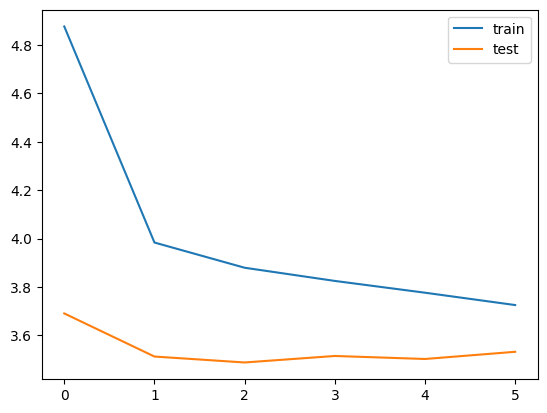

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word # from token int to word -> for y (tr summary)
reverse_source_word_index=x_tokenizer.index_word # from token int to word -> for x(tr text)
target_word_index=y_tokenizer.word_index # from word to token int -> for y(tr summary)

In [ ]:
#Model to summarize between 0-15 words for Summary and 0-300 words for Text
max_text_len=300
max_summary_len=16

# these values are found from the histogram

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, forward_h, forward_c, backward_h, backward_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))


# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2]
)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, forward_h, forward_c, backward_h, backward_c = encoder_model.predict(input_seq,verbose=0)

    e_h = Concatenate()([forward_h, backward_h])
    e_c = Concatenate()([forward_c, backward_c])

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c],verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**INPUT SEQUENCE TO SUMMARY**

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

Run the model over the data to see the results

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):  #  --> padding i.e., WE IGNORE 0
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: টানা দশম সব যেন একে অপরকে টেক্কা দেওয়ার নেমেছে কিন্তু যে সব পর্যটক ও ঘুরে এসেছেন তাঁদের অনেককেই বলতে শোনা যাচ্ছে এ বার কিন্তু তিনটে জলপ্রপাতের মধ্যে হল হিরো নম্বর ওয়ান এই বর্ষায় টেক্কা দেওয়া কঠিন শুরু হয়ে গিয়েছে স্বাধীনতা দিবসের ছুটির মরশুম সোমবার ছুটি নিলেই টানা তিনদিন ধরে ছুটি তাই পর্যটকদের ভিড়ও প্রচুর এমনিতেই দশম খুব জলপ্রপাত গত বছরে দশমের পাথরে বসে স্নান করতে গিয়ে বেশ কয়েকজন পর্যটকের মৃত্যু হয়েছে এবার দশমের এই সচেতন জলপ্রপাতের কর্মীরা তাঁরা বারবার পর্যটকদের জলপ্রপাতের বেশি কাছে যেতে নিষেধ করছেন দশমের রুদ্রমূর্তি দেখে বেশি সাহস দেখানোর চেষ্টা করছেন না কাঁচি নদীর এই জলপ্রপাতের দশটি ধারায় জল পড়ে বলে এর নাম দশম জলপ্রপাত তবে এই বর্ষায় সব জলের ধারা মিলে মিশে একাকার দশম সঙ্গে বিন্দু বিন্দু জল হাওয়ায় উড়িয়ে দিচ্ছে ওই বিন্দু বিন্দু জল একসঙ্গে জমাট বেধে চলে যাচ্ছে অনেক দূর তাই জলপ্রপাত থেকে অনেকটা দূরে দাঁড়িয়ে থাকলেও হালকা ভিজিয়ে দিচ্ছে দশম দশমের এ ভাবেই ভিজতে ভিজতে কোনও এক পর্যটক বলে ওঠেন একেই বলে বোধহয় ভয়ঙ্কর সুন্দর 
Original summary: start সবাইকে টেক্কা দিচ্ছে দশম end 
Predicte

**ROUGE SCORE**

In [ ]:
!pip install rouge

In [ ]:
!pip install rouge-score

In [ ]:
def calculate_precision_recall_fmeasure(predicted_summary, original_summary):
    predicted_set = set(predicted_summary)
    reference_set = set(original_summary)

    # Calculate precision
    precision = len(predicted_set.intersection(reference_set)) / len(predicted_set)


    # Calculate recall
    if len(reference_set) > 0:
        recall = len(predicted_set.intersection(reference_set)) / len(reference_set)
    else:
        recall = 0.0


    # Calculate F-measure
    if precision + recall != 0:
        f_measure = 2 * (precision * recall) / (precision + recall)
    else:
        f_measure = 0.0


    return precision, recall, f_measure

In [ ]:
from rouge import Rouge
rouge=Rouge()

precision = []
recall = []
f_measure = []
Rough_f=[]
Rough_p=[]
Rough_r=[]

for i in range(1000):
    p, r, f= calculate_precision_recall_fmeasure(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    precision.append(p)
    recall.append(r)
    f_measure.append(f)

    # Calculate ROUGE scores using rouge library
    scores = rouge.get_scores(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    Rough_f.append(scores[0]['rouge-1']['f'])
    Rough_p.append(scores[0]['rouge-1']['p'])
    Rough_r.append(scores[0]['rouge-1']['r'])

print("Precision: ", sum(precision)/len(precision))
print("Recall:", sum(recall)/len(recall))
print("F-Measure / F1-Score:", sum(f_measure)/len(f_measure))
print("\nRough:\n\t1. F:", sum(Rough_f)/len(Rough_f),"\n\t2. P:",sum(Rough_p)/len(Rough_p),"\n\t2. R:",sum(Rough_r)/len(Rough_r))

Precision:  0.8341330863924518
Recall: 0.5396400425902748
F-Measure / F1-Score: 0.6462839927955499

Rough:
	1. F: 0.3032058895684539 
	2. P: 0.3900626984126984 
	2. R: 0.2620068598068598


In [ ]:
!pip install evaluate

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize the scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'])

# Initialize variables to store cumulative scores
total_scores = {'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge3': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0}}

num_samples = len(y_tr)

# Use tqdm to create a progress bar
for i in tqdm(range(1000), desc="Calculating ROUGE scores"):
    y_or = seq2summary(y_tr[i])
    y_pred = decode_sequence(x_tr[i].reshape(1, max_text_len))
    scores = scorer.score(y_or, y_pred)

    for key in scores:
        total_scores[key]['precision'] += scores[key].precision
        total_scores[key]['recall'] += scores[key].recall
        total_scores[key]['fmeasure'] += scores[key].fmeasure

# Calculate averages
average_scores = {}
for key in total_scores:
    average_scores[key] = {
        'precision': total_scores[key]['precision'] / num_samples,
        'recall': total_scores[key]['recall'] / num_samples,
        'fmeasure': total_scores[key]['fmeasure'] / num_samples
    }

# Print average scores
for key in average_scores:
    print(f'{key}: Precision={average_scores[key]["precision"]:.4f}, Recall={average_scores[key]["recall"]:.4f}, F1-score={average_scores[key]["fmeasure"]:.4f}')

Calculating ROUGE scores: 100%|██████████| 1000/1000 [12:21<00:00,  1.35it/s]

rouge1: Precision=0.1368, Recall=0.1370, F1-score=0.1369
rouge2: Precision=0.1367, Recall=0.1367, F1-score=0.1367
rouge3: Precision=0.0000, Recall=0.0000, F1-score=0.0000
rougeL: Precision=0.1368, Recall=0.1370, F1-score=0.1369


# **BiLSTM-GRU**

In [ ]:
from keras.layers import Input, Embedding, Bidirectional, LSTM, GRU, RepeatVector, Concatenate, Dense, TimeDistributed
from keras.layers import CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import backend as K
import numpy as np
from keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import pandas as pd
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

# Input lengths
max_text_len = 300
latent_dim = 300
embedding_dim = 300

# Encoder
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(x_voc, embedding_dim, weights=[ft_embedding_matrix_encoder], trainable=True)(encoder_inputs)

# Encoder Layer
encoder_bilstm_1 = Bidirectional(CuDNNLSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bilstm_1(enc_emb)

encoder_bilstm_2 = Bidirectional(CuDNNLSTM(latent_dim, return_sequences=True, return_state=True))
encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bilstm_2(encoder_output1)

encoder_bilstm = Bidirectional(CuDNNLSTM(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_output2)

# Concatenate the forward and backward states
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(input_dim=y_voc, output_dim=embedding_dim, weights=[ft_embedding_matrix_decoder], trainable=True)(decoder_inputs)

decoder_gru = CuDNNGRU(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_h = decoder_gru(dec_emb, initial_state=state_h)

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)

model.summary()

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     9322800     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  [(None, 300, 600),   1444800     ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300),                                                     
                                 (None, 300),                                                 

In [ ]:
# we remove the last word [:,:-1] & the first word [:,1:] so that the model can predict the next one
#reshape is done because the decoder expects a 3d tensor
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128,verbose=1, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
58/58 [==============================] - 62s 907ms/step - loss: 4.9591 - val_loss: 3.6868
Epoch 2/50
58/58 [==============================] - 44s 762ms/step - loss: 3.9739 - val_loss: 3.4981
Epoch 3/50
58/58 [==============================] - 44s 762ms/step - loss: 3.8659 - val_loss: 3.4936
Epoch 4/50
58/58 [==============================] - 39s 673ms/step - loss: 3.8003 - val_loss: 3.4735
Epoch 5/50
58/58 [==============================] - 43s 735ms/step - loss: 3.7256 - val_loss: 3.4564
Epoch 6/50
58/58 [==============================] - 39s 662ms/step - loss: 3.6350 - val_loss: 3.4524
Epoch 7/50
58/58 [==============================] - 39s 666ms/step - loss: 3.5391 - val_loss: 3.4745
Epoch 8/50
58/58 [==============================] - 39s 673ms/step - loss: 3.4361 - val_loss: 3.4768
Epoch 9/50
58/58 [==============================] - 41s 707ms/step - loss: 3.3193 - val_loss: 3.4814
Epoch 9: early stopping


In [ ]:
import tensorflow as tf

# Assuming you have already defined and compiled your model
# Save the model weights
model.save_weights("/content/drive/MyDrive/IITG/BiLSTM_GRU_weights.h5")

In [ ]:
import tensorflow as tf

# Load the saved model weights
model.load_weights("/content/drive/MyDrive/IITG/BiLSTM_GRU_weights.h5")

**Visualize the model learning**

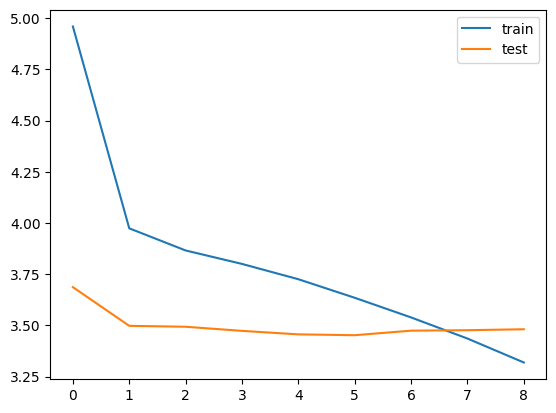

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word # from token int to word -> for y (tr summary)
reverse_source_word_index=x_tokenizer.index_word # from token int to word -> for x(tr text)
target_word_index=y_tokenizer.word_index # from word to token int -> for y(tr summary)

In [ ]:
#Model to summarize between 0-15 words for Summary and 0-300 words for Text
max_text_len=300
max_summary_len=16

# these values are found from the histogram

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim*2))

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2 = decoder_gru(dec_emb, initial_state=decoder_state_input_h)

# A dense softmax layer to generate probability distribution over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h],
    [decoder_outputs2] + [state_h2]
)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of the target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [e_h], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit the max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) >= (max_summary_len - 1):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h = h

    return decoded_sentence

**INPUT SEQUENCE TO SUMMARY**

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

Run the model over the data to see the results

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):  #  --> padding i.e., WE IGNORE 0
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: টানা দশম সব যেন একে অপরকে টেক্কা দেওয়ার নেমেছে কিন্তু যে সব পর্যটক ও ঘুরে এসেছেন তাঁদের অনেককেই বলতে শোনা যাচ্ছে এ বার কিন্তু তিনটে জলপ্রপাতের মধ্যে হল হিরো নম্বর ওয়ান এই বর্ষায় টেক্কা দেওয়া কঠিন শুরু হয়ে গিয়েছে স্বাধীনতা দিবসের ছুটির মরশুম সোমবার ছুটি নিলেই টানা তিনদিন ধরে ছুটি তাই পর্যটকদের ভিড়ও প্রচুর এমনিতেই দশম খুব জলপ্রপাত গত বছরে দশমের পাথরে বসে স্নান করতে গিয়ে বেশ কয়েকজন পর্যটকের মৃত্যু হয়েছে এবার দশমের এই সচেতন জলপ্রপাতের কর্মীরা তাঁরা বারবার পর্যটকদের জলপ্রপাতের বেশি কাছে যেতে নিষেধ করছেন দশমের রুদ্রমূর্তি দেখে বেশি সাহস দেখানোর চেষ্টা করছেন না কাঁচি নদীর এই জলপ্রপাতের দশটি ধারায় জল পড়ে বলে এর নাম দশম জলপ্রপাত তবে এই বর্ষায় সব জলের ধারা মিলে মিশে একাকার দশম সঙ্গে বিন্দু বিন্দু জল হাওয়ায় উড়িয়ে দিচ্ছে ওই বিন্দু বিন্দু জল একসঙ্গে জমাট বেধে চলে যাচ্ছে অনেক দূর তাই জলপ্রপাত থেকে অনেকটা দূরে দাঁড়িয়ে থাকলেও হালকা ভিজিয়ে দিচ্ছে দশম দশমের এ ভাবেই ভিজতে ভিজতে কোনও এক পর্যটক বলে ওঠেন একেই বলে বোধহয় ভয়ঙ্কর সুন্দর 
Original summary: start সবাইকে টেক্কা দিচ্ছে দশম end 
Predicte

**ROUGE SCORE**

In [ ]:
!pip install rouge

In [ ]:
!pip install rouge-score

In [ ]:
def calculate_precision_recall_fmeasure(predicted_summary, original_summary):
    predicted_set = set(predicted_summary)
    reference_set = set(original_summary)

    # Calculate precision
    precision = len(predicted_set.intersection(reference_set)) / len(predicted_set)


    # Calculate recall
    if len(reference_set) > 0:
        recall = len(predicted_set.intersection(reference_set)) / len(reference_set)
    else:
        recall = 0.0


    # Calculate F-measure
    if precision + recall != 0:
        f_measure = 2 * (precision * recall) / (precision + recall)
    else:
        f_measure = 0.0


    return precision, recall, f_measure

In [ ]:
from rouge import Rouge
rouge=Rouge()

precision = []
recall = []
f_measure = []
Rough_f=[]
Rough_p=[]
Rough_r=[]

for i in range(1000):
    p, r, f= calculate_precision_recall_fmeasure(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    precision.append(p)
    recall.append(r)
    f_measure.append(f)

    # Calculate ROUGE scores using rouge library
    scores = rouge.get_scores(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    Rough_f.append(scores[0]['rouge-1']['f'])
    Rough_p.append(scores[0]['rouge-1']['p'])
    Rough_r.append(scores[0]['rouge-1']['r'])

print("Precision: ", sum(precision)/len(precision))
print("Recall:", sum(recall)/len(recall))
print("F-Measure / F1-Score:", sum(f_measure)/len(f_measure))
print("\nRough:\n\t1. F:", sum(Rough_f)/len(Rough_f),"\n\t2. P:",sum(Rough_p)/len(Rough_p),"\n\t2. R:",sum(Rough_r)/len(Rough_r))

Precision:  0.7016363636363637
Recall: 0.5778613921689336
F-Measure / F1-Score: 0.6261691452234536

Rough:
	1. F: 0.2791585615843551 
	2. P: 0.33933333333333326 
	2. R: 0.25107091797091796


In [ ]:
!pip install evaluate

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize the scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'])

# Initialize variables to store cumulative scores
total_scores = {'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge3': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0}}

num_samples = len(y_tr)

# Use tqdm to create a progress bar
for i in tqdm(range(1000), desc="Calculating ROUGE scores"):
    y_or = seq2summary(y_tr[i])
    y_pred = decode_sequence(x_tr[i].reshape(1, max_text_len))
    scores = scorer.score(y_or, y_pred)

    for key in scores:
        total_scores[key]['precision'] += scores[key].precision
        total_scores[key]['recall'] += scores[key].recall
        total_scores[key]['fmeasure'] += scores[key].fmeasure

# Calculate averages
average_scores = {}
for key in total_scores:
    average_scores[key] = {
        'precision': total_scores[key]['precision'] / num_samples,
        'recall': total_scores[key]['recall'] / num_samples,
        'fmeasure': total_scores[key]['fmeasure'] / num_samples
    }

# Print average scores
for key in average_scores:
    print(f'{key}: Precision={average_scores[key]["precision"]:.4f}, Recall={average_scores[key]["recall"]:.4f}, F1-score={average_scores[key]["fmeasure"]:.4f}')

Calculating ROUGE scores: 100%|██████████| 1000/1000 [09:42<00:00,  1.72it/s]

rouge1: Precision=0.1368, Recall=0.1370, F1-score=0.1369
rouge2: Precision=0.1367, Recall=0.1367, F1-score=0.1367
rouge3: Precision=0.0000, Recall=0.0000, F1-score=0.0000
rougeL: Precision=0.1368, Recall=0.1370, F1-score=0.1369


# **GRU - GRU**

In [ ]:
from keras import backend as K
import fasttext as ft
from numpy import *
import numpy as np
import pandas as pd
from keras.layers import Input, GRU, Embedding, Dense, TimeDistributed
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from keras.layers import CuDNNGRU
K.clear_session()

# Assuming FastText was trained with an embedding dimension of 300
embedding_dim = 300
latent_dim = 300
max_text_len = 300

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

# Embedding layer with FastText embeddings for the encoder
enc_emb = Embedding(x_voc, embedding_dim, weights=[ft_embedding_matrix_encoder], trainable=True)(encoder_inputs)

# Encoder GRU layers
encoder_gru1 = CuDNNGRU(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1 = encoder_gru1(enc_emb)

encoder_gru2 = CuDNNGRU(latent_dim, return_sequences=True, return_state=True)
encoder_output2, state_h2 = encoder_gru2(encoder_output1)

encoder_gru3 = CuDNNGRU(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h = encoder_gru3(encoder_output2)

# Decoder
decoder_inputs = Input(shape=(None,))

# Embedding layer with FastText embeddings for the decoder
dec_emb_layer = Embedding(y_voc, embedding_dim, weights=[ft_embedding_matrix_decoder], trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder GRU layers
decoder_gru = CuDNNGRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, decoder_state = decoder_gru(dec_emb, initial_state=state_h)

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')

# Early Stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 300, 300)     9322800     ['input_1[0][0]']                
                                                                                                  
 cu_dnngru (CuDNNGRU)           [(None, 300, 300),   541800      ['embedding[0][0]']              
                                 (None, 300)]                                                     
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                           

In [ ]:
# we remove the last word [:,:-1] & the first word [:,1:] so that the model can predict the next one
#reshape is done because the decoder expects a 3d tensor
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128,verbose=1, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
58/58 [==============================] - 30s 441ms/step - loss: 5.3500 - val_loss: 3.8615
Epoch 2/50
58/58 [==============================] - 21s 366ms/step - loss: 4.1092 - val_loss: 3.5441
Epoch 3/50
58/58 [==============================] - 21s 369ms/step - loss: 3.9324 - val_loss: 3.5074
Epoch 4/50
58/58 [==============================] - 19s 329ms/step - loss: 3.8724 - val_loss: 3.5161
Epoch 5/50
58/58 [==============================] - 19s 327ms/step - loss: 3.8230 - val_loss: 3.5006
Epoch 6/50
58/58 [==============================] - 18s 308ms/step - loss: 3.7669 - val_loss: 3.4854
Epoch 7/50
58/58 [==============================] - 17s 293ms/step - loss: 3.7020 - val_loss: 3.4696
Epoch 8/50
58/58 [==============================] - 16s 273ms/step - loss: 3.6341 - val_loss: 3.4755
Epoch 9/50
58/58 [==============================] - 17s 293ms/step - loss: 3.5648 - val_loss: 3.4791
Epoch 10/50
58/58 [==============================] - 16s 282ms/step - loss: 3.4904 - val_lo

In [ ]:
import tensorflow as tf

# Assuming you have already defined and compiled your model
# Save the model weights
model.save_weights("/content/drive/MyDrive/IITG/GRU_GRU_weights.h5")

In [ ]:
import tensorflow as tf

# Load the saved model weights
model.load_weights("/content/drive/MyDrive/IITG/GRU_GRU_weights.h5")

**Visualize the model learning**

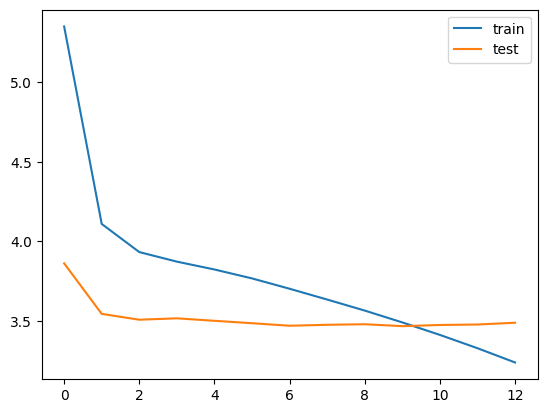

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word # from token int to word -> for y (tr summary)
reverse_source_word_index=x_tokenizer.index_word # from token int to word -> for x(tr text)
target_word_index=y_tokenizer.word_index # from word to token int -> for y(tr summary)

In [ ]:
#Model to summarize between 0-15 words for Summary and 0-300 words for Text
max_text_len=300
max_summary_len=16

# these values are found from the histogram

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs, state_h2 = decoder_gru(dec_emb, initial_state=decoder_state_input_h)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_state_input_h],
    [decoder_outputs2] + [state_h2]
)

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h = encoder_model.predict(input_seq,verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h= decoder_model.predict([target_seq] + [e_h],verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h = h

    return decoded_sentence


**INPUT SEQUENCE TO SUMMARY**

Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:

Run the model over the data to see the results

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):  #  --> padding i.e., WE IGNORE 0
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(0,10):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: টানা দশম সব যেন একে অপরকে টেক্কা দেওয়ার নেমেছে কিন্তু যে সব পর্যটক ও ঘুরে এসেছেন তাঁদের অনেককেই বলতে শোনা যাচ্ছে এ বার কিন্তু তিনটে জলপ্রপাতের মধ্যে হল হিরো নম্বর ওয়ান এই বর্ষায় টেক্কা দেওয়া কঠিন শুরু হয়ে গিয়েছে স্বাধীনতা দিবসের ছুটির মরশুম সোমবার ছুটি নিলেই টানা তিনদিন ধরে ছুটি তাই পর্যটকদের ভিড়ও প্রচুর এমনিতেই দশম খুব জলপ্রপাত গত বছরে দশমের পাথরে বসে স্নান করতে গিয়ে বেশ কয়েকজন পর্যটকের মৃত্যু হয়েছে এবার দশমের এই সচেতন জলপ্রপাতের কর্মীরা তাঁরা বারবার পর্যটকদের জলপ্রপাতের বেশি কাছে যেতে নিষেধ করছেন দশমের রুদ্রমূর্তি দেখে বেশি সাহস দেখানোর চেষ্টা করছেন না কাঁচি নদীর এই জলপ্রপাতের দশটি ধারায় জল পড়ে বলে এর নাম দশম জলপ্রপাত তবে এই বর্ষায় সব জলের ধারা মিলে মিশে একাকার দশম সঙ্গে বিন্দু বিন্দু জল হাওয়ায় উড়িয়ে দিচ্ছে ওই বিন্দু বিন্দু জল একসঙ্গে জমাট বেধে চলে যাচ্ছে অনেক দূর তাই জলপ্রপাত থেকে অনেকটা দূরে দাঁড়িয়ে থাকলেও হালকা ভিজিয়ে দিচ্ছে দশম দশমের এ ভাবেই ভিজতে ভিজতে কোনও এক পর্যটক বলে ওঠেন একেই বলে বোধহয় ভয়ঙ্কর সুন্দর 
Original summary: start সবাইকে টেক্কা দিচ্ছে দশম end 
Predicte

**ROUGE SCORE**

In [ ]:
!pip install rouge

In [ ]:
!pip install rouge-score

In [ ]:
def calculate_precision_recall_fmeasure(predicted_summary, original_summary):
    predicted_set = set(predicted_summary)
    reference_set = set(original_summary)

    # Calculate precision
    precision = len(predicted_set.intersection(reference_set)) / len(predicted_set)


    # Calculate recall
    if len(reference_set) > 0:
        recall = len(predicted_set.intersection(reference_set)) / len(reference_set)
    else:
        recall = 0.0


    # Calculate F-measure
    if precision + recall != 0:
        f_measure = 2 * (precision * recall) / (precision + recall)
    else:
        f_measure = 0.0


    return precision, recall, f_measure

In [ ]:
from rouge import Rouge
rouge=Rouge()

precision = []
recall = []
f_measure = []
Rough_f=[]
Rough_p=[]
Rough_r=[]

for i in range(1000):
    p, r, f= calculate_precision_recall_fmeasure(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    precision.append(p)
    recall.append(r)
    f_measure.append(f)

    # Calculate ROUGE scores using rouge library
    scores = rouge.get_scores(decode_sequence(x_tr[i].reshape(1, max_text_len)), seq2summary(y_tr[i]))
    Rough_f.append(scores[0]['rouge-1']['f'])
    Rough_p.append(scores[0]['rouge-1']['p'])
    Rough_r.append(scores[0]['rouge-1']['r'])

print("Precision: ", sum(precision)/len(precision))
print("Recall:", sum(recall)/len(recall))
print("F-Measure / F1-Score:", sum(f_measure)/len(f_measure))
print("\nRough:\n\t1. F:", sum(Rough_f)/len(Rough_f),"\n\t2. P:",sum(Rough_p)/len(Rough_p),"\n\t2. R:",sum(Rough_r)/len(Rough_r))

Precision:  0.7556190476190477
Recall: 0.5960804443031232
F-Measure / F1-Score: 0.6583735272364308

Rough:
	1. F: 0.2528159085072577 
	2. P: 0.26375 
	2. R: 0.2586409923409923


In [ ]:
!pip install evaluate

In [ ]:
from rouge_score import rouge_scorer

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rouge3', 'rougeL'], use_stemmer=True)

In [ ]:
from rouge_score import rouge_scorer
from tqdm import tqdm

# Initialize the scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rouge3', 'rougeL'])

# Initialize variables to store cumulative scores
total_scores = {'rouge1': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge2': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rouge3': {'precision': 0, 'recall': 0, 'fmeasure': 0},
                'rougeL': {'precision': 0, 'recall': 0, 'fmeasure': 0}}

num_samples = len(y_tr)

# Use tqdm to create a progress bar
for i in tqdm(range(1000), desc="Calculating ROUGE scores"):
    y_or = seq2summary(y_tr[i])
    y_pred = decode_sequence(x_tr[i].reshape(1, max_text_len))
    scores = scorer.score(y_or, y_pred)

    for key in scores:
        total_scores[key]['precision'] += scores[key].precision
        total_scores[key]['recall'] += scores[key].recall
        total_scores[key]['fmeasure'] += scores[key].fmeasure

# Calculate averages
average_scores = {}
for key in total_scores:
    average_scores[key] = {
        'precision': total_scores[key]['precision'] / num_samples,
        'recall': total_scores[key]['recall'] / num_samples,
        'fmeasure': total_scores[key]['fmeasure'] / num_samples
    }

# Print average scores
for key in average_scores:
    print(f'{key}: Precision={average_scores[key]["precision"]:.4f}, Recall={average_scores[key]["recall"]:.4f}, F1-score={average_scores[key]["fmeasure"]:.4f}')


Calculating ROUGE scores: 100%|██████████| 1000/1000 [11:39<00:00,  1.43it/s]

rouge1: Precision=0.1368, Recall=0.1370, F1-score=0.1369
rouge2: Precision=0.1367, Recall=0.1367, F1-score=0.1367
rouge3: Precision=0.0000, Recall=0.0000, F1-score=0.0000
rougeL: Precision=0.1368, Recall=0.1370, F1-score=0.1369
